In [1]:
import gpaw
import ase
import matplotlib.pyplot as plt
import numpy as np

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [57]:
def spc(ss):
    d = 1.1
    h2 = ase.Atoms('H2', [(0, 0, 0), (0, 0, d)])
    h2.center(vacuum=2.5)
    s = 1.0
    pc = gpaw.external.PointChargePotential([-s, -s], h2.get_positions())
    pc=None
    bg = gpaw.jellium.Jellium(-1)
    bg=None
    calc = gpaw.GPAW(mode=gpaw.PW(ss), background_charge=bg, xc='LDA', txt='h2.txt', external=pc)
    h2.set_calculator(calc)
    h2.get_potential_energy()
    n  = calc.get_all_electron_density()
    dv = h2.get_volume() / calc.get_number_of_grid_points().prod()
    print (calc.get_pseudo_density().sum()*dv)
    return h2
#q = spc(0.9)

In [3]:
def plot_calc(sys, label, axis):
    calc = sys.calc
    gridrefinement = 1  # needs to be 1!
    gridpos = calc.density.gd.get_grid_point_coordinates()
    dens = calc.get_all_electron_density(gridrefinement=gridrefinement)
    dv = sys.get_volume() / calc.get_number_of_grid_points().prod()
    dens *= dv / gridrefinement**3
    print ('total n electrons', dens.sum())
    xs = []
    ys = []
    gridz = sorted(set(gridpos[axis].reshape(-1)))
    for idx in range(len(gridz)):
        xs.append(gridz[idx])
        ys.append(np.sum(dens[np.where(gridpos[axis] == gridz[idx])]))
    plt.plot(xs, ys, label=label)
    plt.ylim(0, max(ys)*1.1)
    plt.legend()

In [210]:
def jellium():
    k = 5
    h = 0.2
    a = 5
    j = gpaw.jellium.Jellium(2)
    bulk = ase.Atoms(pbc=True, cell=(a, a, a))
    pc = gpaw.external.PointChargePotential([1.,], [[1,1,1]], rc=0.01, rc2=1)
    #calc = gpaw.GPAW(mode=gpaw.PW(200.0), background_charge=j, xc='LDA',nbands=4,kpts=[k, k, k],h=h,txt='jellium.txt',external=pc)
    calc = gpaw.GPAW(mode=gpaw.PW(200.0), background_charge=j, xc='LDA',nbands=8,kpts=[k, k, k],h=h,txt='jellium.txt',external=pc)
    bulk.calc = calc
    e0 = bulk.get_potential_energy()
    return bulk
qj = jellium()

0.999391588967436
total n electrons 0.9999999999999416
0.9998172204094753
total n electrons 0.9999999999999851
0.9999924215625247
total n electrons 1.0000000000000024
0.9999988940610852
total n electrons 1.0000000000000238


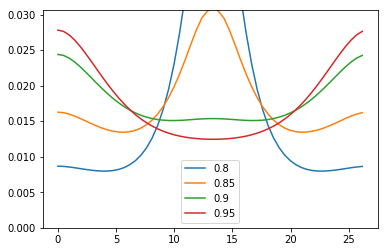

In [33]:
for sval in (0.8,0.85,0.9,0.95,):
    plot_calc(spc(sval), str(sval), 2)

1.999411008329714
total n electrons 1.9999999999996771
1.9997890374980645
total n electrons 2.000000000000472
1.9999696596490977
total n electrons 1.9999999999999356
1.9999945548563778
total n electrons 1.9999999999999203


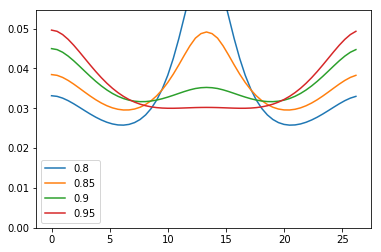

In [39]:
for sval in (0.8,0.85,0.9,0.95,):
    plot_calc(spc(sval), str(sval), 2)

1.9737140224699494
total n electrons 2.0000000000000493
1.9737144407682887
total n electrons 2.000000000000038
1.976132714376689
total n electrons 1.9999999999999964


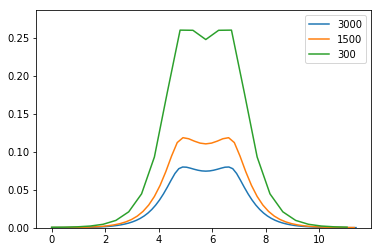

In [58]:
for sval in (3000,1500, 300):
    plot_calc(spc(sval), str(sval), 2)

1.9999038060438534
total n electrons 2.000000000000013
1.9999036900546494
total n electrons 2.0000000000000244
1.9998938010370448
total n electrons 1.9999999999999414


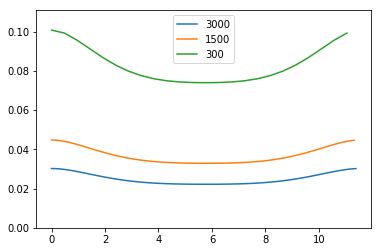

In [52]:
for sval in (3000,1500, 300):
    plot_calc(spc(sval), str(sval), 2)

In [195]:
# box size, num k points, pwcutoff, numintermediate, gridspacing
# required: 
# systems: dimers

In [2]:
def example():
    from ase import Atoms
    from ase.units import Hartree, Bohr

    from gpaw import GPAW
    from gpaw.xc import XC
    from gpaw.test import equal
    from gpaw.xc.kernel import XCNull
    from gpaw.poisson import NoInteractionPoissonSolver
    from gpaw.external import ExternalPotential


    a = 4.0
    x = Atoms(cell=(a, a, a), pbc=True)  # no atoms


    class HarmonicPotential(ExternalPotential):
        def calculate_potential(self, gd):
            r_vg = gd.get_grid_point_coordinates()
            self.vext_g = 0.5 * ((r_vg - a / Bohr / 2)**2).sum(0)

        def get_name(self):
            return 'HarmonicPotential'


    calc = GPAW(charge=-8,
                nbands=4,
                h=0.2,
                xc=XC(XCNull()),
                external=HarmonicPotential(),
                poissonsolver=NoInteractionPoissonSolver(),
                eigensolver='cg')

    x.calc = calc
    x.get_potential_energy()

def jellium2():
    k = 5
    h = 0.2
    a = 5
    class HarmonicPotential(gpaw.external.ExternalPotential):
        def calculate_potential(self, gd):
            r_vg = gd.get_grid_point_coordinates()
            xs = np.abs(r_vg[0] - 1)**2
            ys = np.abs(r_vg[1] - 1)**2
            zs = np.abs(r_vg[2] - 1)**2
            ds = np.sqrt(xs+ys+zs)
            self.vext_g = 1./ds
            #self.vext_g = r_vg.sum(0) * 0
            #self.vext_g[20, 20, 20] = 100
        def get_name(self):
            return 'HarmonicPotential'
    j = gpaw.jellium.Jellium(2)
    bulk = ase.Atoms(pbc=True, cell=(a, a, a))
    pc = gpaw.external.PointChargePotential([1.,], [[1,1,1]], rc=0.01, rc2=1)
    #calc = gpaw.GPAW(mode=gpaw.PW(200.0), background_charge=j, xc='LDA',nbands=4,kpts=[k, k, k],h=h,txt='jellium.txt',external=pc)
    calc = gpaw.GPAW(mode=gpaw.PW(200.0), background_charge=j, xc='LDA',nbands=8,kpts=[k, k, k],h=h,txt='jellium.txt',external=HarmonicPotential())
    bulk.calc = calc
    e0 = bulk.get_potential_energy()
    return bulk
qj2 = jellium2()


total n electrons 2.000000000006261


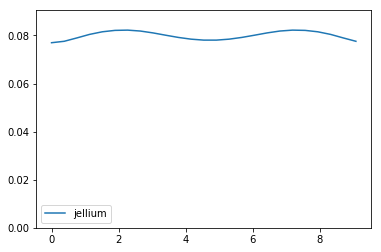

In [4]:
plot_calc(qj2, 'jellium', 2)